In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# From Matplotlib documentation
def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log2(np.abs(matrix).max()))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix.T + 1e-13):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)
        
    ax.set_xticks(np.arange(1, width) - 0.5)
    ax.set_yticks(np.arange(1, height) - 0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid()

    ax.autoscale_view()
    ax.invert_yaxis()

Filtering
\begin{align}
p(x_t | y_{t-1}) &= \int p(x_{t}|x_{t-1}) p(x_{t-1}|y_{t-1}) \mathrm d x_t \\
p(x_t | y_{t}) &= \frac{p(y_t|x_t)p(x_t | y_{t-1})}{Z}
\end{align}

In [3]:
width = 12
height = 10
movement = True
obs_noise = 1
obs_prob = 0.6

In [4]:
def sample_transition(x):
    if movement:
        delta = np.array([np.random.randint(-1, 2), np.random.randint(-1, 2)])
        if np.abs(delta).sum() == 2:
            delta = np.array([0, 0])  # So 5/9 probability of staying in the same spot
        x = (x + delta) % np.array([height, width])
    return x

def sample_observation(x):
    if np.random.rand() < obs_prob:
        delta = np.array([np.random.randint(-obs_noise, obs_noise+1), np.random.randint(-obs_noise, obs_noise+1)])
        x = (x + delta) % np.array([height, width])
        return x
    else:
        return None

In [5]:
xall = []
yall = []
# x = np.array([np.random.randint(0, height), np.random.randint(0, width)])
x = np.array([height // 2, width // 2])
for t in range(10000):
    x = sample_transition(x)
    xall.append(x)
    yall.append(sample_observation(x) if t > 0 else None)
xall = np.vstack(xall)

In [6]:
def visual(x, y=None):
    img = np.zeros((height, width))
    img[x[0], x[1]] = 1
    if y is not None:
        img[y[0], y[1]] = 0.5
    return img

def plot_state(img):
    fig, ax = plt.subplots()
    ims = ax.imshow(img, vmin=0, cmap='Greys_r')
    ax.set_xticks(np.arange(1, width) - 0.5)
    ax.set_yticks(np.arange(1, height) - 0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid()
    
def transition_prob(x):
    if movement:
        img = visual(x)
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 or dy == 0:
                    img[(x[0] + dy) % height, (x[1] + dx) % width] = 1 / 9
        img[x[0], x[1]] = 5/9
        img = img / np.sum(img)  # Normalise probability
    return img

def observe_prob(x):
    img = visual(x)
    for dx in np.arange(-obs_noise, obs_noise+1):
        for dy in np.arange(-obs_noise, obs_noise+1):
            img[(x[0] + dy) % height, (x[1] + dx) % width] = 1
    img = img / np.sum(img)  # Normalise probability
    return img

def likelihood(y):
    if y is not None:
        return observe_prob(y)
    else:
        return 1.0

def forward(p_xt):
    px_tp1 = np.zeros((height, width))
    for (y, x), w in np.ndenumerate(p_xt):
        px_tp1 = px_tp1 + transition_prob([y, x]) * w
    return px_tp1

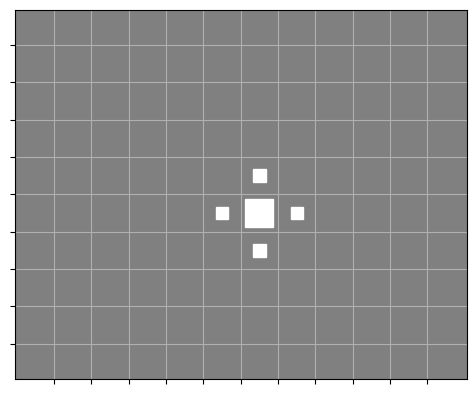

In [7]:
hinton(transition_prob([height // 2, width // 2]))

In [8]:
t = 0
post = np.ones((height, width)) / (height * width)

1 [5 4]


<Figure size 640x480 with 0 Axes>

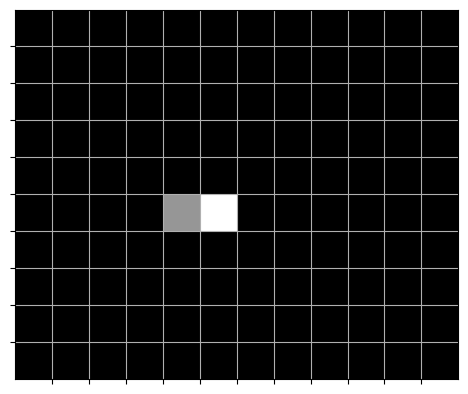

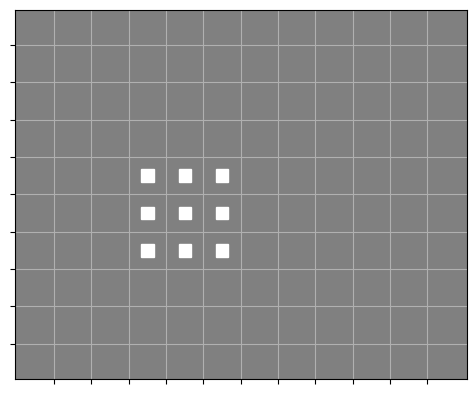

In [11]:
plt.figure(); plot_state(visual(xall[t, :], yall[t]))
# plt.figure(); hinton(transition_prob(xall[t, :]) + 1e-6, max_weight=1.0)
# plt.figure(); hinton(observe_prob(xall[t, :]) + 1e-6, max_weight=1.0)
post = post * likelihood(yall[t])
post = post / post.sum()
plt.figure(); hinton(post, max_weight=1.0)
post = forward(post)
# plt.figure(); hinton(post, max_weight=1.0)
print(t, yall[t])
t += 1

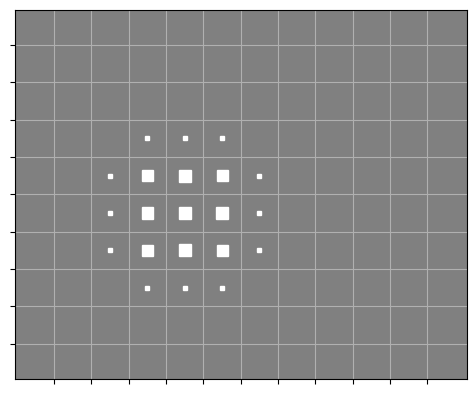

In [12]:
plt.figure(); hinton(post, max_weight=1.0)